<a href="https://colab.research.google.com/github/Hotckiss/DUL/blob/hw3_2/hw3p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import pickle

import numpy as np
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

#PATH_DATA = os.path.join('data', 'hw3-q2.pkl')
PATH_DATA = os.path.join('drive', 'My Drive', 'hw3-q2.pkl')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
with open(PATH_DATA, 'rb') as file:
    dataset = pickle.load(file)
    
xs_train = dataset['train']
xs_val = dataset['valid']

In [0]:
batch_size = 2 ** 10

def collate_fn(xs):
    xs = torch.tensor(xs, dtype=torch.float32)
    xs = xs * 2 / 255 - 1
    xs = xs.permute(0, 3, 1, 2)
    return xs

train_data_loader = data.DataLoader(
    dataset=xs_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_fn
)
val_data_loader = data.DataLoader(
    dataset=xs_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    collate_fn=collate_fn
)

In [0]:
class GatedShortcutConnection(nn.Module):
    def __init__(self, channels=128):
        super(GatedShortcutConnection, self).__init__()
                 
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
                 
    def forward(self, x):
        return self.conv1(x) * self.sigmoid(self.conv2(x))

In [0]:
class ResidualStack(nn.Module):
    def __init__(self, channels=64):
        super(ResidualStack, self).__init__()
                 
        in_channels = channels * 4
            
        layers = []
        for _ in range(5):
            layers += [
                nn.Conv2d(in_channels, channels, kernel_size=3, padding=1, bias=False),
                nn.ReLU(),
                nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
                nn.ReLU(),
                GatedShortcutConnection(channels=channels * 2),
                nn.ReLU(),
            ]
            in_channels = channels * 2
        self.layers = nn.Sequential(*layers)
                 
    def forward(self, x):
        return self.layers(x)

In [0]:
class Encoder(nn.Module):
    def __init__(self, channels):
        super(Encoder, self).__init__()
        
        self.channels = channels
        
        layers = [
            nn.Conv2d(3, self.channels * 2, 
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(self.channels * 2, self.channels * 4,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(self.channels * 4, self.channels * 4,
                      kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            ResidualStack(self.channels),
            nn.Conv2d(self.channels * 2, self.channels * 4,
                      kernel_size=1)
        ]
        self.layers = nn.Sequential(*layers)
                 
    def forward(self, x):
        x = self.layers(x)
        x = x.reshape(-1, 2, 2 * self.channels, 8, 8)
        mu, log_var = x[:, 0], x[:, 1]
        var = torch.exp(log_var)
        return mu, var

In [0]:
class Decoder(nn.Module):
    def __init__(self, channels):
        super(Decoder, self).__init__()
        
        self.channels = channels
        
        layers = [
            nn.Conv2d(self.channels * 2, self.channels * 4,
                      kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            ResidualStack(self.channels),
            nn.ConvTranspose2d(self.channels * 2, self.channels * 2,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(self.channels * 2, 3 * 2,
                               kernel_size=4, stride=2, padding=1, bias=False)
        ]
        self.layers = nn.Sequential(*layers)
                 
    def forward(self, x):
        x = self.layers(x)
        x = x.reshape(-1, 2, 3, 32, 32)
        mu, log_var = x[:, 0], x[:, 1]
        var = torch.exp(log_var)
        return mu, var

In [0]:
class VAE(nn.Module):
    def __init__(self, channels=64):
        super(VAE, self).__init__()
        
        self.channels = channels
        
        self.encoder = Encoder(channels)
        self.decoder = Decoder(channels)
        
    def get_latent_size(self):
        return [2 * self.channels, 8, 8]
    
    def reparameterize(self, mu, var):
        eps = torch.randn_like(mu, device=device)
        z = mu + eps * torch.sqrt(var)
        return z
            
    def encode(self, x, training=True):
        mu, var = self.encoder(x)
        z = self.reparameterize(mu, var)
        return (mu, var, z) if training else mu
    
    def decode(self, z):
        return self.decoder(z)
            
    def forward(self, x):
        mu_z, var_z, z = self.encode(x)
        mu_x, var_x = self.decode(z)
        return (mu_z, var_z), mu_x, var_x

In [0]:
class MSELoss(nn.Module):
    def __init__(self):
        super(MSELoss, self).__init__()
        
    def forward(self, mu, var, x):
        prob = -0.5 * (torch.log(np.pi * 2 * var) + (x - mu) ** 2 / var)
        loss = -prob.mean()
        return loss

In [0]:
class KLLossStandard(nn.Module):
    def __init__(self):
        super(KLLossStandard, self).__init__()
        
    def forward(self, mu, var):
        kl_div = 1.0 + torch.log(var) - mu ** 2 - var
        kl_div = -0.5 * kl_div
        loss = kl_div.mean()
        return loss

In [0]:
def train(model, criterion_mse, criterion_kl,
          optimizer, scheduler, epochs):
    losses_mse_train = []
    losses_kl_train = []
    losses_train = []
    losses_mse_val = []
    losses_kl_val = []
    losses_val = []
    for i in trange(epochs):
        losses_mse = []
        losses_kl = []
        losses = []
        model.train()
        for xs in train_data_loader:
            xs = xs.to(device)
            
            optimizer.zero_grad()

            z_data, mu_x, var_x = model(xs)
            
            loss_mse = criterion_mse(mu_x, var_x, xs)
            loss_kl = criterion_kl(*z_data)
            loss = loss_mse + loss_kl

            losses_mse.append(loss_mse.item())
            losses_kl.append(loss_kl.item())
            losses.append(loss.item())

            loss.backward()
            optimizer.step()

        losses_mse_train.append(np.array(losses_mse).mean())
        losses_kl_train.append(np.array(losses_kl).mean())
        losses_train.append(np.array(losses).mean())

        losses_mse = []
        losses_kl = []
        losses = []
        model.eval()
        with torch.no_grad():
            for xs in val_data_loader:
                xs = xs.to(device)

                z_data, mu_x, var_x = model(xs)

                loss_mse = criterion_mse(mu_x, var_x, xs)
                loss_kl = criterion_kl(*z_data)
                loss = loss_mse + loss_kl

                losses_mse.append(loss_mse.item())
                losses_kl.append(loss_kl.item())
                losses.append(loss.item())

        losses_mse_val.append(np.array(losses_mse).mean())
        losses_kl_val.append(np.array(losses_kl).mean())
        losses_val.append(np.array(losses).mean())
        
        if scheduler:
            scheduler.step()
    return losses_mse_train, losses_mse_val, losses_kl_train, losses_kl_val, losses_train, losses_val
    
    plt.plot(range(epochs), losses_mse_train, label="train")
    plt.plot(range(epochs), losses_mse_val, label="val")
    plt.xlabel('epoch num')
    plt.ylabel('loss mse')
    plt.legend()
    plt.show()

    plt.plot(range(epochs), losses_kl_train, label="train")
    plt.plot(range(epochs), losses_kl_val, label="val")
    plt.xlabel('epoch num')
    plt.ylabel('loss KL')
    plt.legend()
    plt.show()

    plt.plot(range(epochs), losses_train, label="train")
    plt.plot(range(epochs), losses_val, label="val")
    plt.xlabel('epoch num')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [0]:
def plot_(train, val, title_):
    plt.plot(range(epochs), train, label="train")
    plt.plot(range(epochs), val, label="val")
    plt.xlabel('N')
    plt.ylabel(title_)
    plt.legend()
    plt.show()

In [0]:
def show_interpolation(model, n=5, m=10):
    sample_ids = list(range(n))
    samples_a = xs_train[sample_ids]
    samples_b = xs_train[sample_ids[-1:] + sample_ids[:-1]]
    samples_a = collate_fn(samples_a).to(device)
    samples_b = collate_fn(samples_b).to(device)
    
    images = []
    with torch.no_grad():
        for i in range(n):
            a, b = samples_a[i], samples_b[i]
            za, zb = model.encode(a[None, :], training=False), model.encode(b[None, :], training=False)
            for j in range(m):
                x, _ = model.decode(za + (zb - za) * j / (m - 1))
                x = x.permute(0, 2, 3, 1).cpu().numpy()[0]
                images.append(x)
            
    images = np.array(images)
    images = (images + 1) / 2
    images = np.clip(images, 0, 1)
    
    f, axarr = plt.subplots(n, m)
    f.set_figheight(15)
    f.set_figwidth(8)
    for i, img in enumerate(images):
        axarr[n - 1 - i // m, i % m].imshow(img)
        axarr[n - 1 - i // m, i % m].axis('off')
    plt.show()

In [0]:
def show_samples(model, n=9):
    z = torch.randn([n, *model.get_latent_size()]).to(device)
    
    with torch.no_grad():
        images, _ = model.decode(z)
        images = images.permute(0, 2, 3, 1).cpu().numpy()
        
    images = (images + 1) / 2
    images = np.clip(images, 0, 1)
    
    n = int(np.ceil(np.sqrt(n)))
    f, axarr = plt.subplots(n, n)
    f.set_figheight(4)
    f.set_figwidth(4)
    for i, img in enumerate(images):
        axarr[i // n, i % n].imshow(img)
        axarr[i // n, i % n].axis('off')
    plt.show()

In [0]:
epochs = 40
lr = 0.0002
w_l2 = 0

model = VAE(channels=32)
model.to(device)

criterion_mse = MSELoss()
criterion_kl = KLLossStandard()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)

In [21]:
losses_mse_train, losses_mse_val, losses_kl_train, losses_kl_val, losses_train, losses_val = train(model, criterion_mse, criterion_kl, optimizer, None, epochs)

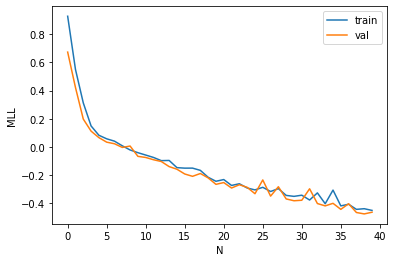

In [35]:
plot_(losses_mse_train, losses_mse_val, "MLL")

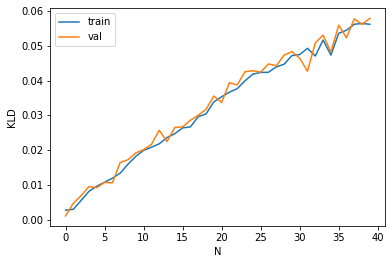

In [36]:
plot_(losses_kl_train, losses_kl_val, "KLD")

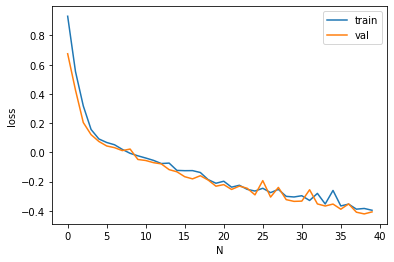

In [37]:
plot_(losses_train, losses_val, "loss")

In [0]:
torch.save(model.state_dict(), "./tmp.pt")

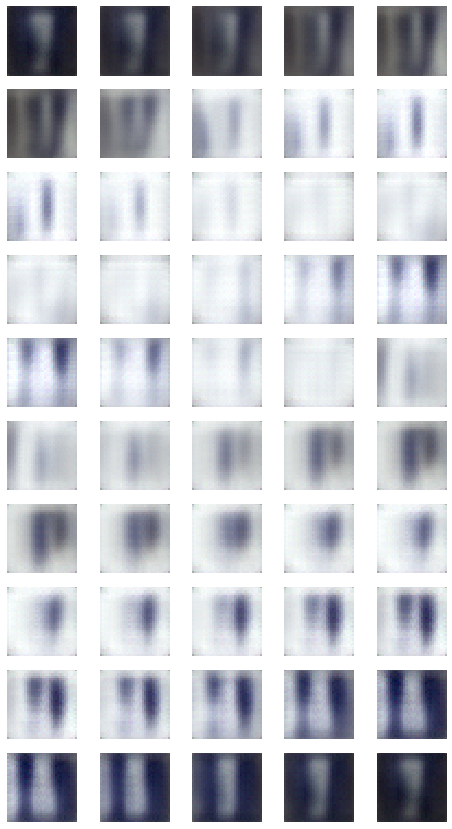

In [33]:
model.eval()
show_interpolation(model, 10, 5)

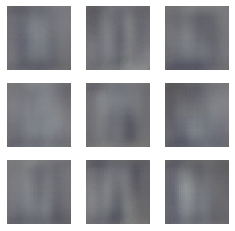

In [34]:
show_samples(model)

In [0]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        
        self.register_buffer('mask', torch.ones_like(self.weight))
        _, _, h, w = self.mask.size()
        self.mask[:, :, h // 2, w // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, h // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

In [0]:
class MaskResBlock(nn.Module):
    def __init__(self, h=128):
        super(MaskResBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(2 * h, h, 1),
            nn.BatchNorm2d(h),
            nn.ReLU(),
            MaskedConv2d('B', h, h, 3, 1, 1),
            nn.BatchNorm2d(h),
            nn.ReLU(),
            nn.Conv2d(h, 2 * h, 1),
            nn.BatchNorm2d(2 * h)
        )

    def forward(self, x):
        x = self.layers(x) + x
        return x

In [0]:
class PixelCNN(nn.Module):
    def __init__(self, h=128):
        super(PixelCNN, self).__init__()
        
        layers = [MaskedConv2d('A', h, 2 * h, 3, 1, 1)]
        layers += [MaskResBlock(h) for _ in range(3)]
        layers += [nn.Conv2d(2 * h, 2 * h, kernel_size=1)]
        self.layers = nn.Sequential(*layers)
            
    def forward(self, x):
        x = self.layers(x)
        x = x.reshape(-1, 2, x.shape[1] // 2, 8, 8)
        mu, log_var = x[:, 0], x[:, 1]
        var = torch.exp(log_var)
        return mu, var

In [0]:
class VAEPixelCNN(nn.Module):
    def __init__(self, channels=64):
        super(VAEPixelCNN, self).__init__()
        
        self.channels = channels
        
        self.encoder = Encoder(channels)
        
        self.pixel_cnn = PixelCNN(2 * channels)
        
        self.decoder = Decoder(channels)
        
    def get_latent_size(self):
        return [2 * self.channels, 8, 8]
    
    def reparameterize(self, mu, var):
        eps = torch.randn_like(mu, device=device)
        z = mu + eps * torch.sqrt(var)
        return z
            
    def encode(self, x, training=True):
        mu_z1, var_z1 = self.encoder(x)
        z = self.reparameterize(mu_z1, var_z1)
        mu_z2, var_z2 = self.pixel_cnn(z)
        return (mu_z1, var_z1, mu_z2, var_z2, z) if training else mu_z1
    
    def decode(self, z):
        return self.decoder(z)
            
    def forward(self, x):
        mu_z1, var_z1, mu_z2, var_z2, z = self.encode(x)
        mu_x, var_x = self.decode(z)
        return (mu_z1, var_z1, mu_z2, var_z2, z), mu_x, var_x

In [0]:
class KLLoss(nn.Module):
    def __init__(self):
        super(KLLoss, self).__init__()
        
    def get_prob(self, mu, var, x):
        return -0.5 * (torch.log(np.pi * 2 * var) + (x - mu) ** 2 / var)
        
    def forward(self, mu_z1, var_z1, mu_z2, var_z2, z):
        p1 = self.get_prob(mu_z1, var_z1, z)
        p2 = self.get_prob(mu_z2, var_z2, z)
        loss = (p1 - p2).mean()
        return loss

In [0]:
def show_samples_pixel_cnn(model, n=100):
    z = torch.randn([n, *model.get_latent_size()]).to(device)
    
    _, h, w = model.get_latent_size()
    with torch.no_grad():
        for y in range(h):
            for x in range(w):
                mu, var = model.pixel_cnn(z)
                mu, var = mu[:, :, y, x], var[:, :, y, x]
                z[:, :, y, x] = model.reparameterize(mu, var)

        images, _ = model.decode(z)
        images = images.permute(0, 2, 3, 1).cpu().numpy()
        
    images = (images + 1) / 2
    images = np.clip(images, 0, 1)
    
    n = int(np.ceil(np.sqrt(n)))
    f, axarr = plt.subplots(n, n)
    f.set_figheight(15)
    f.set_figwidth(15)
    for i, img in enumerate(images):
        axarr[i // n, i % n].imshow(img)
        axarr[i // n, i % n].axis('off')
    plt.show()

In [0]:
epochs = 100
lr = 0.0002
w_l2 = 0

model = VAEPixelCNN(channels=32)
model.to(device)

criterion_mse = MSELoss()
criterion_kl = KLLoss()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)

train(model, criterion_mse, criterion_kl, optimizer, None, epochs)

In [0]:
model.eval()
show_interpolation(model, 10, 10)

In [0]:
show_samples_pixel_cnn(model)